In [2]:
import re

def count_words(text):
    """
    Count the number of words in the provided text.
    
    :param text: A string containing the text to be analyzed.
    :return: The number of words in the text.
    """
    words = re.findall(r'\b\w+\b', text)
    return len(words)


In [3]:
import pandas as pd
import os
import re
from typing import Dict, Any
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', None)

def classify_paragraph(text : str, lines_count : int, **kwargs : Dict[str, Any]):
    """
    Classify a paragraph based on its content.

    :param text: Text of the paragraph.
    :param lines_count: Number of lines in the paragraph.
    :return: The category of the paragraph.
    """
    chapter_match = re.search(r'(CHAPTER [IVXLCDMN]+): [^:]+', text, re.IGNORECASE)
    dialogue_match = re.search(r'(DIALOGUE [IVXLCDMN]+): [^:]+', text, re.IGNORECASE)
    
    if chapter_match:
        return 'chapter-header', chapter_match.group(1)
    elif dialogue_match:
        return 'dialogue-header', dialogue_match.group(1)
    elif text.startswith('*'):
        return 'formula', 'formula'
    elif text.startswith('Introduction:') or (lines_count == 1 and not text[-1] in ['.', '!', '?', ';', ')', ':', '}', ',', '-', '"'] \
        and text[0] == text[0].upper() and text[0].isalpha() and not text.isupper() \
            and not '(' in text):
        return 'header', 'header'
    elif re.match(r'^[^: ]+:\s+.+', text):
        return 'dialogue', 'dialogue'
    else:
        return 'text', 'text'

def build_paragraphs(text_file_path : str):
    """
    Read a text file and split it into chunks.

    :param text_file_path: Path to the text file.
    :param chunk_size: Number of lines in each chunk.
    :return: List of text chunks.
    """
    current = []
    lineno = -1
    idx = 0
    with open(text_file_path, 'r') as file:
        print(f"Reading {text_file_path}")
        for line in file:
            lineno += 1
            if line.strip() == '':
                if len(current) > 0:
                    text = ' '.join(current)
                    yield idx, lineno, text, len(text), len(current)
                    idx += 1
                    current = []
            else:
                current.append(line.strip())

    if len(current) > 0:
        text = ' '.join(current)
        yield idx, lineno, text, len(text), len(current)

def chunks_to_parquet(chunks, output_dir):
    """
    Convert chunks of text to Parquet files.

    :param chunks: List of text chunks.
    :param output_dir: Directory to save Parquet files.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, chunk in enumerate(chunks, start=1):
        df = pd.DataFrame(chunk, columns=['text'])
        parquet_path = os.path.join(output_dir, f'chunk_{i}.parquet')
        df.to_parquet(parquet_path, index=False)
        
def assign_cluster_ids(df):
    """
    Assign cluster IDs to each paragraph based on its type and compute cluster sizes.

    :param df: DataFrame with paragraph data and categories.
    :return: DataFrame with 'cluster' and 'cluster_size' columns.
    """
    current_clusters = {category: 0 for category in df['category'].unique()}
    last_category = None

    cluster_ids = []

    for _, row in df.iterrows():
        category = row['category']

        if category != last_category:
            current_clusters[category] += 1
            last_category = category

        cluster_id = f"{category}_{current_clusters[category]}"
        cluster_ids.append(cluster_id)

    df['cluster'] = cluster_ids

    # Compute cluster sizes
    cluster_sizes = df['cluster'].value_counts()
    df['cluster_size'] = df['cluster'].map(cluster_sizes)

    return df

def fuzz_cluster_edges(df):
    """
    Adjust the clustering by comparing adjacent rows. If the next or previous categories match,
    set the fuzz_cluster to the current cluster.

    :param df: DataFrame with paragraph data, categories, and initial clusters.
    :return: DataFrame with adjusted cluster columns.
    """

    # Initialize fuzz_cluster with current cluster values
    df['fuzz_cluster'] = None

    # Update fuzz_cluster based on adjacent categories
    for idx in df.index:
        if idx == 0:
            df.at[idx, 'fuzz_cluster'] = df.at[idx, 'cluster']
            df.at[idx, 'chapter'] = df.at[idx, 'category_id']
        if idx > 0:
            if df.at[idx, 'category'] == 'header' or df.at[idx, 'category'] == 'dialogue-header' or df.at[idx, 'category'] == 'chapter-header':
                # One excecption, if we are a header and the previous is a header or chapter-header, we are in the same cluster
                if df.at[idx - 1, 'category'] == 'header' or df.at[idx - 1, 'category'] == 'chapter-header':
                    df.at[idx, 'fuzz_cluster'] = df.at[idx - 1, 'fuzz_cluster']
                else:
                    df.at[idx, 'fuzz_cluster'] = df.at[idx, 'cluster']
            else:
                df.at[idx, 'fuzz_cluster'] = df.at[idx - 1, 'fuzz_cluster']
            if df.at[idx, 'category'] == 'chapter-header' or df.at[idx, 'category'] == 'dialogue-header':
                df.at[idx, 'chapter'] = df.at[idx, 'category_id']
            else:
                df.at[idx, 'chapter'] = df.at[idx - 1, 'chapter']

    # Compute fuzzed cluster sizes
    fuzz_cluster_sizes = df['fuzz_cluster'].value_counts()
    df['fuzz_cluster_size'] = df['fuzz_cluster'].map(fuzz_cluster_sizes)

    return df

def extend_dialogue_clusters_full(df):
    """
    Extend dialogue clusters to include the preceding and following headers and any text in between.

    :param df: DataFrame with paragraph data, categories, fuzz clusters, and sizes.
    :return: DataFrame with fully extended dialogue clusters.
    """
    # Iterate over the DataFrame to find dialogue clusters and extend them
    for idx, row in df.iterrows():
        if row['category'] == 'dialogue':
            current_cluster = row['fuzz_cluster']

            # Extend backwards to the previous header
            for prev_idx in range(idx - 1, -1, -1):
                prev_row = df.iloc[prev_idx]
                df.at[prev_idx, 'fuzz_cluster'] = current_cluster
                if prev_row['category'] == 'header':
                    break

            # Extend forwards to the next header
            for next_idx in range(idx + 1, len(df)):
                next_row = df.iloc[next_idx]
                if next_row['category'] == 'header':
                    break
                df.at[next_idx, 'fuzz_cluster'] = current_cluster

    # Recompute fuzzed cluster sizes
    fuzz_cluster_sizes = df['fuzz_cluster'].value_counts()
    df['fuzz_cluster_size'] = df['fuzz_cluster'].map(fuzz_cluster_sizes)

    return df

def extend_text_clusters(df):
    """
    Extend text clusters upwards until encountering another text or dialogue cluster.

    :param df: DataFrame with paragraph data, categories, fuzz clusters, and sizes.
    :return: DataFrame with extended text clusters.
    """
    for idx, row in df.iterrows():
        if row['category'] == 'text':
            current_cluster = row['fuzz_cluster']

            # Extend backwards until another text or dialogue cluster is found
            for prev_idx in range(idx - 1, -1, -1):
                prev_row = df.iloc[prev_idx]
                if prev_row['category'] in ['text', 'dialogue']:
                    break
                df.at[prev_idx, 'fuzz_cluster'] = current_cluster

    # Recompute fuzzed cluster sizes
    fuzz_cluster_sizes = df['fuzz_cluster'].value_counts()
    df['fuzz_cluster_size'] = df['fuzz_cluster'].map(fuzz_cluster_sizes)

    return df

# A dataset that had the header and footer hand cleaned
text_file_path = '../geb.txt'
output_dir = './geb.parquet'
chunk_size = 1000  # Number of lines per chunk

paragraphs = list(build_paragraphs(text_file_path))
#chunks_to_parquet(chunks, output_dir)

df = pd.DataFrame(paragraphs, columns=['idx', 'lineno', 'text', 'text_length', 'lines_count'])
intro = df[:100]
df = df[100:].reset_index(drop=True)
df[['category', 'category_id']] = df.apply(lambda row: classify_paragraph(**row), axis=1, result_type='expand')
df = assign_cluster_ids(df)
df = fuzz_cluster_edges(df)
df['word_count'] = df['text'].apply(count_words)
df['cumsum_word_count'] = df['word_count'].cumsum()
# Apply the function to extend dialogue clusters
#df = extend_dialogue_clusters_full(df)
#df = extend_text_clusters(df)

#df.set_index('idx', inplace=True)
#headers = df[df['category'] == 'header']
# Read the idx + 1 for each header
#nextix = df.loc[(headers.index + 1)[:-2]]
#previx = df.loc[(headers.index - 1)[1:]]

df.to_parquet('books/geb.parquet', index=False)
#df[500:550].agg

Reading ./books/geb.txt


In [25]:
# We are going to draw from this dataset to create a new dataset
import random
import pandas as pd 
from typing import Literal

def select_rows_until_max_word_count(df, start_bin, max_word_count):
    """
    Selects rows starting from the specified bin until the cumulative word count 
    reaches or exceeds the maximum word count.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        start_bin (int): The index of the starting bin (row).
        max_word_count (int): The maximum cumulative word count.

    Returns:
        int: The index of the last row included in the selection.
    """

    current_sum = 0
    for index, row in df.loc[start_bin:].iterrows():
        current_sum += row['word_count']
        if current_sum >= max_word_count:
            return index

    # If the end of the DataFrame is reached without exceeding max_word_count
    return df.index[-1]['idx']

def build_strides(outclass : Literal['chapter', 'dialogue'] = 'chapter', context : int = 8192):
    df = pd.read_parquet('geb.parquet')
    df['is_chapter'] = df['chapter'].str.startswith('CHAPTER')
    df = df[df['is_chapter'] == (outclass == 'chapter')]
    # err on the large size, the number of tokens in a word averages to 4:3.  we should use the tokenizer in geb.parquet to get the token counts instead.
    word_count = context * 3 / 4
    df['cumsum_word_count'] = df['word_count'].cumsum()
    # Calculate total word count (last value in cumsum)
    last_row = df.iloc[-1]
    total_word_count = df['cumsum_word_count'].iloc[-1]
    # Now go backwards and find the index of the bin that contains the 8192nd word
    selected_bin = df[df['cumsum_word_count'] < total_word_count - word_count - 200].iloc[-1]
    total_word_count = selected_bin["cumsum_word_count"]
    print(selected_bin, total_word_count, last_row)
    samples = []

    for i in range(5000):
        rand_num = random.uniform(0, total_word_count)
        rand_end = rand_num + word_count
        if rand_end > total_word_count:
            rand_end = total_word_count
        selected_bin = df[df['cumsum_word_count'] >= rand_num].iloc[0]['idx'] - 100
        end_bin = df[df['cumsum_word_count'] >= rand_end].iloc[0]['idx'] - 100
        #print(f"Random number: {rand_num} {rand_end} {selected_bin} {end_bin}")
        text = []
        for i in range(selected_bin, end_bin - 1):
            if i not in df.index:
                break
            text.append(df['text'][i])

        samples.append({
            "text": "<s>" + "</s><s>".join(text) + "</s>",
        })

    del df['is_chapter']

    pd.DataFrame(samples).reset_index().to_parquet(f'./geb-strides-{outclass}-{context}.parquet', index=False)


In [ ]:
build_strides('chapter', 8192)
build_strides('dialogue', 8192)

In [8]:

def aggregate_by_fuzz_cluster(df):
    """
    Aggregate the DataFrame by fuzz_cluster with custom aggregation for each column.

    :param df: DataFrame with various columns.
    :return: DataFrame with aggregated data for each fuzz_cluster.
    """
    aggregations = {
        'chapter': 'first',
        'idx': 'min', 
        'lineno': 'min', 
        'word_count': 'sum', 
        'text_length': 'sum', 
        'text': lambda x: '\n\n'.join(x), 
        'lines_count': 'sum', 
        'category': lambda x: ', '.join(sorted(set(x))),
        'category_id': 'first',
        'cluster': lambda x: ', '.join(sorted(set(x))),
        'cluster_size': 'sum', 
        'fuzz_cluster_size': 'sum'
    }

    aggregated_df = df.groupby('fuzz_cluster').agg(aggregations)

    return aggregated_df

aggregated_df = aggregate_by_fuzz_cluster(df)
aggregated_df = aggregated_df.reset_index().set_index(['chapter', 'fuzz_cluster'])
ndf = aggregated_df.sort_values('idx').reset_index()
df[['chapter', 'fuzz_cluster', 'idx', 'lineno', 'word_count', 'text_length','lines_count', 'category', 'category_id', 'cluster_size', 'fuzz_cluster_size']].head()

chapter      fuzz_cluster  idx  lineno  word_count  text_length  \
0  CHAPTER N  chapter-header_1  100     381           7           50   
1  CHAPTER N  chapter-header_1  101     389          90          552   
2  CHAPTER N  chapter-header_1  102     402         167          981   
3  CHAPTER N          header_1  103     404           1            4   
4  CHAPTER N          header_1  104     412         101          593   

   lines_count        category category_id  cluster_size  fuzz_cluster_size  
0            1  chapter-header   CHAPTER N             1                  3  
1            7            text        text             2                  3  
2           12            text        text             2                  3  
3            1          header      header             1                  6  
4            7            text        text             5                  6

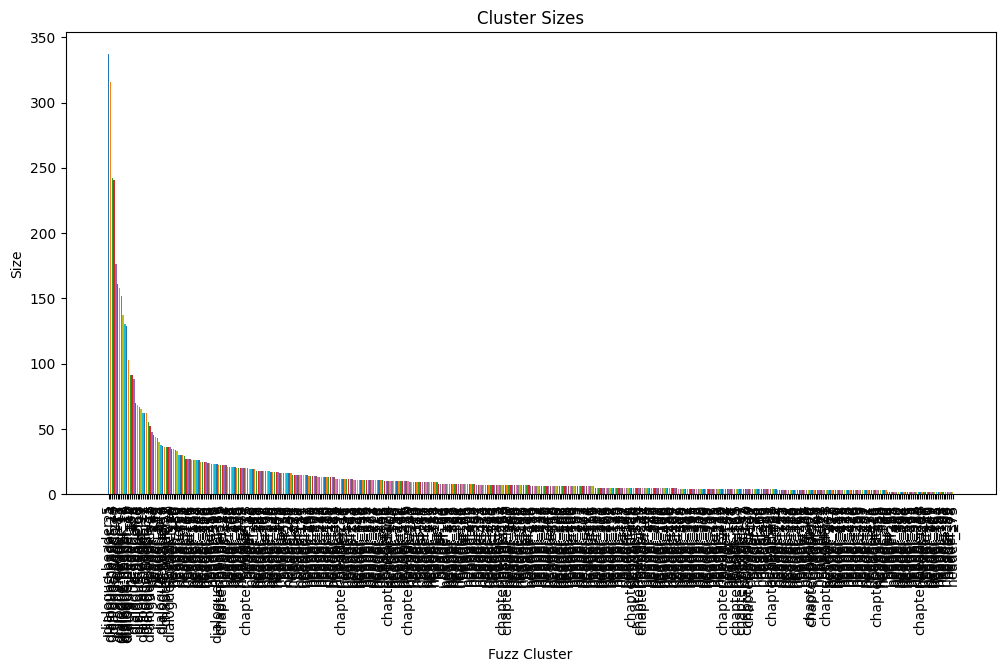

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_clusters(df):
    """
    Create a high-contrast plot of fuzz_clusters.

    :param df: DataFrame with paragraph data and extended dialogue clusters.
    """
    # Get the size of each cluster
    cluster_sizes = df['fuzz_cluster'].value_counts()

    # Generate a list of unique colors for the clusters
    colors = list(mcolors.TABLEAU_COLORS) * (len(cluster_sizes) // len(mcolors.TABLEAU_COLORS) + 1)

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(cluster_sizes.index, cluster_sizes.values, color=colors[:len(cluster_sizes)])

    # Set plot title and labels
    plt.title('Cluster Sizes')
    plt.xlabel('Fuzz Cluster')
    plt.ylabel('Size')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

    # Show the plot
    plt.show()

# Plot the clusters
plot_clusters(df)


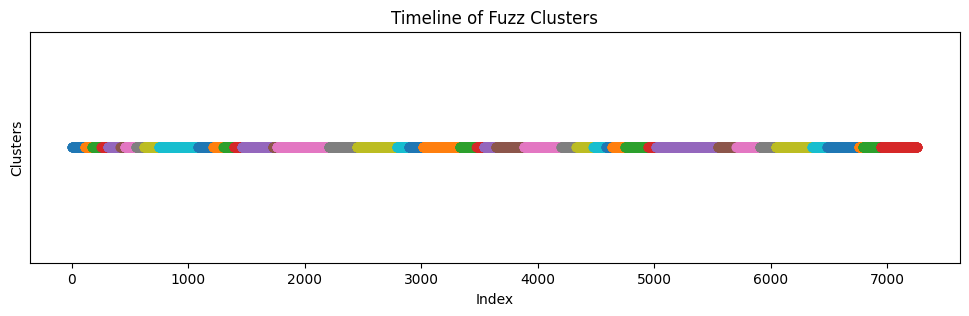

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_timeline_clusters(df):
    """
    Create a timeline plot of fuzz_clusters with the DataFrame index on the x-axis.

    :param df: DataFrame with paragraph data and extended dialogue clusters.
    """
    # Map clusters to colors
    unique_clusters = df['chapter'].unique()
    colors = list(mcolors.TABLEAU_COLORS) * (len(unique_clusters) // len(mcolors.TABLEAU_COLORS) + 1)
    color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

    # Create the scatter plot
    plt.figure(figsize=(12, 3))
    for cluster in unique_clusters:
        cluster_indices = df[df['chapter'] == cluster].index
        plt.scatter(cluster_indices, np.repeat(1, len(cluster_indices)), color=color_map[cluster], label=cluster, alpha=1)

    # Set plot title and labels
    plt.title('Timeline of Fuzz Clusters')
    plt.xlabel('Index')
    plt.ylabel('Clusters')
    plt.yticks([])  # Hide y-axis ticks
    #plt.legend(title='Chapter', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside

    # Show the plot
    plt.show()

# Plot the timeline of clusters
plot_timeline_clusters(df)


In [11]:
def aggregate_by_fuzz_cluster(df):
    """
    Aggregate the DataFrame by fuzz_cluster with custom aggregation for each column.

    :param df: DataFrame with various columns.
    :return: DataFrame with aggregated data for each fuzz_cluster.
    """
    aggregations = {
        'chapter': 'first',
        'idx': 'min', 
        'lineno': 'min', 
        'text_length': 'sum', 
        'word_count': 'sum', 
        'text': lambda x: '\n\n'.join(x), 
        'lines_count': 'sum', 
        'category': lambda x: ', '.join(sorted(set(x))),
        'category_id': 'first',
        'cluster': lambda x: ', '.join(sorted(set(x))),
        'cluster_size': 'sum', 
        'fuzz_cluster_size': 'sum'
    }

    aggregated_df = df.groupby('fuzz_cluster').agg(aggregations)

    return aggregated_df

# Assuming df is your DataFrame with the fuzz_cluster and other columns
aggregated_df = aggregate_by_fuzz_cluster(df)
aggregated_df = aggregated_df.reset_index().set_index(['chapter', 'fuzz_cluster'])

# Display the aggregated DataFrame
#aggregated_df.sort_values('lineno', ascending=True)
ndf = aggregated_df.reset_index()
ndf[ndf['chapter'] == "DIALOGUE XXI"][['chapter', 'fuzz_cluster', 'idx', 'lineno', 'text_length','lines_count', 'category', 'category_id', 'cluster_size', 'fuzz_cluster_size']]


chapter        fuzz_cluster   idx  lineno  text_length  lines_count  \
36  DIALOGUE XXI  dialogue-header_21  7044   30650        53501          782   

                           category   category_id  cluster_size  \
36  dialogue, dialogue-header, text  DIALOGUE XXI          6714   

    fuzz_cluster_size  
36              99856